# GGM exporteren tbv GEMMA

Dit notebook wordt gebruikt om vanuit de beschikbare versie van het [Gemeentelijk Gegevensmodel](https://github.com/Gemeente-Delft/Gemeentelijk-Gegevensmodel) een export te maken van van het GGM zodat deze in de GEMMA ingelezen kan worden. Dit in het kader van de uitwisseling met de GEMMA. Alle beoogde uitwisselingen in het kader van de uitwisseling van het GGM met de GEMMA zijn in onderstaande afbeelding weergegeven.

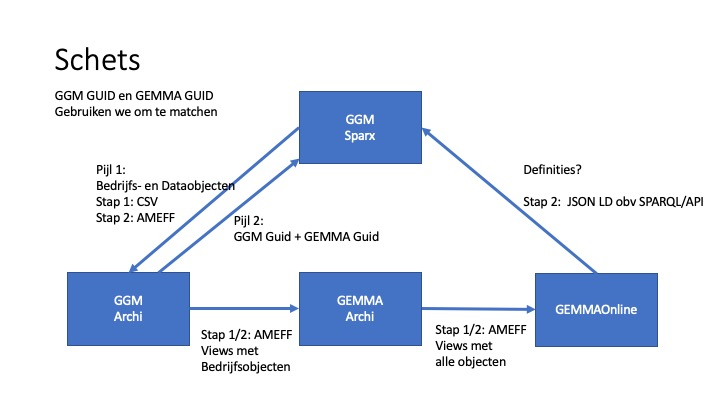

Dit notebook verzorgt de export vanuit het GGM naar de GEMMA conform Pijl 1, Stap 1 in de afbeelding. De gegevens worden geëxporteerd conform de afspraken vastgelegd in [Uitwisseling GGM en GEMMA](https://github.com/Gemeente-Delft/Gemeentelijk-Gegevensmodel/tools/docs/Uitwisseling_GGM_en_GEMMA.pptx) De volgende definities worden geëxporteerd: 

1. objecttypes
2. relaties

## Werking Export

De exportmodule maakt gebruik van het feit dat het GGM is vastgelegd in Enterprise Architect van Sparx en dat deze de repository van het GGM in [Sqllite](https://www.sqlite.org/index.html) wordt bijgehouden. Deze exportmodule leest de benodigde tabellen uit de repository, voegt ze samen en maakt een exportbestand dat naar GEMMA verstuurd kan worden.


In [1]:
### Importeer bibliotheken en utils

import os
import pandas as pd
import json
from IPython.display import JSON as JSONDisplay
import requests
import database
import util
from re import sub
import ast
import re
from treelib import Node, Tree
from datetime import datetime, timezone
import pytz

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, inspect
from sqlalchemy.engine import reflection

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Sequence
from sqlalchemy.dialects.postgresql import insert
import uuid

def generateEAUUID():
    return '{' +  str(uuid.uuid4()).upper() + '}'

## Configuratie

Met de waarden hieronder configureer je de export. Met root_guid geef je de root in de repository weer vanwaar (en alles eronder) geexporteerd moet worden. Op deze manier kun je ook deelmodellen exporteren. Als voorbeeld zijn naast de root van het hele GGM ook Onderwijs en monumenten getoond.  

In [2]:
### Configuratie
db_uri = "/home/jovyan/root/v2.3.0/gemeentelijk gegevensmodel EA16.qea"


now = datetime.now()
dt_string = now.strftime("%d%m%Y-%H%M%S")
output_objects = f"/home/jovyan/output/ggm_export_objects_{dt_string}.csv"
output_relations = f"/home/jovyan/output/ggm_export_relations_{dt_string}.csv"
#output_attributes = f"./output/ggm_export_attributes_{dt_string}.csv"

root_guid = '{604AC59D-D038-4e78-A5FA-80E4748DED5B}' #Om te experimenteren: Onderwijs in package ontwikkeling
root_guid = '{45B88627-6F44-4b6d-BE77-3EC51BBE679E}' #Om te experimenteren: Monumenten
root_guid = '{58A5214F-E56C-4707-BE2D-AB36DD6976A3}' #Om te experimenteren: RSGB
root_guid = '{D7FD597E-1F40-48df-AFFC-EA3B5B5D3FBF}' # Root GGM

obj_columns = ['GGM-naam', 'GGM-definitie', 'GGM-uml-type', 'GGM-toelichting', 'GGM-synoniemen', 'GGM-guid', 'GGM-bron', 'domein-iv3', 'domein-dcat', 'domein-gemma', 'GEMMA-naam', 'GEMMA-definitie', 'GEMMA-toelichting', 'GEMMA-synoniemen', 'GEMMA-bron', 'GEMMA-URL', 'GEMMA-alternate-name', 'GEMMA-guid', 'GEMMA-type', 'datum-tijd-export'] 
obj_column_mapping = {'name': 'GGM-naam', 'object_type': 'GGM-uml-type', 'ea_guid': 'GGM-guid', 'herkomst': 'GGM-bron', 'note': 'GGM-definitie', 'toelichting': 'GGM-toelichting', 'synoniemen': 'GGM-synoniemen', 'archimate-type': 'GEMMA-type', 'gemma-guid': 'GEMMA-guid'}

#obj_columns = ['GGM-naam', 'GEMMA-naam', 'GGM-guid', 'GEMMA-guid', 'GEMMA-type', 'GGM-uml-type', 'GGM-definitie', 'GEMMA-definitie', 'GGM-toelichting', 'GEMMA-toelichting', 'GGM-synoniemen', 'GEMMA-synoniemen', 'GGM-bron', 'GEMMA-bron', 'GEMMA-URL', 'GEMMA-alternate-name', 'domein-dcat', 'domein-iv3', 'Datum-tijd-export'] 
#obj_column_mapping = {'ea_guid': 'GGM-guid', 'name': 'GGM-naam', 'herkomst': 'GGM-bron', 'objectnote': 'GGM-definitie', 'synoniemen': 'GGM-synoniemen', 'toelichting': 'GGM-toelichting'}

#attr_columns = ['naam', 'definitie', 'archimate-datatype', 'uml-datatype', 'gemma-guid', 'ggm-guid', 'gemma-object-guid', 'ggm-object-guid', 'bron', 'toelichting', 'synoniemen', 'datum-tijd-export'] 
#attr_column_mapping = {'name': 'naam', 'type': 'uml-datatype', 'ea_guid': 'ggm-guid', 'ea_guid_object': 'ggm-object-guid', 'herkomst': 'bron', 'notes': 'definitie'}

con_columns = ['naam', 'definitie', 'archimate-type', 'uml-type', 'gemma-guid', 'ggm-guid', 'gemma-source-guid', 'gemma-target-guid', 'ggm-source-guid', 'ggm-target-guid', 'toelichting', 'datum-tijd-export'] #, 'domein-iv3', 'domein-dcat', 'domein-gemma'] 
con_columns = ['GGM-naam', 'GGM-definitie', 'GGM-uml-type', 'GGM-toelichting', 'GGM-guid', 'GGM-source-guid', 'GGM-target-guid', 'GEMMA-naam', 'GEMMA-definitie', 'GEMMA-toelichting', 'GEMMA-type', 'GEMMA-guid', 'GEMMA-source-guid', 'GEMMA-target-guid', 'datum-tijd-export'] 
con_column_mapping = {'connector_name': 'GGM-naam', 'connector_type': 'GGM-uml-type', 'ea_guid': 'GGM-guid', 'note': 'GGM-definitie', 'toelichting': 'GGM-toelichting', 'ea_guid_source': 'GGM-source-guid', 'ea_guid_target': 'GGM-target-guid'}

## Inlezen Objecttypes

Hieronder wordt het model (vanaf 'root_guid' en alles daaronder) ingelezen in het dataframe df voor verdere verwerking. Achtereenvolgens worden de volgende stappen genomen:

1. alle packages (in een tree)
2. alle objecten (classes, enumeraties en waardelijsten) met alle waarden.
3. filteren van objecten op de te exporteren waardes

In [3]:
# Alle packages inlezen en omzetten in tree structure
df_package = database.get_df(db_uri, "select * from t_package")
df_package['Name'] = df_package['Name'].apply(lambda x: util.verwijder_getallen_en_blanks_vooraan(x))

# Zoek de ID van de root value and get Package tree
root_id = df_package[df_package.ea_guid == root_guid]['Package_ID'].values[0]
package_tree = util.DataframeToTree(df_package, 'Package_ID', 'Parent_ID', 4)
#package_tree.show()

df_package

Package_ID                                Name  Parent_ID  \
0             1                               Model          0   
1             3   Delfts Gemeentelijk Gegevensmodel          1   
2             4  Bestuur, Politiek en Ondersteuning          3   
3             5                         Burgerzaken          4   
4             6                             Diagram          5   
..          ...                                 ...        ...   
320         322               Terug- en invordering        308   
321         323                           Datatypes        322   
322         324                             Diagram        322   
323         325         Model Terug- en invordering        322   
324         326                       Model Inkomen        308   

             CreatedDate         ModifiedDate  \
0    2012-04-17 00:01:01  2012-04-17 00:01:01   
1    2018-04-04 15:03:05  2025-03-27 17:11:20   
2    2023-10-12 14:31:31  2025-03-26 16:14:34   
3    2018-04-04 15:05:22  2025-03-26 16:14:34   
4    2018-07-12 16:10:28  2025-03-26 16:14:34   
..                   ...                  ...   
320  2024-06-27 21:51:28  2025-03-27 15:34:19   
321  2024-06-27 21:51:28  2025-03-27 15:28:35   
322  2024-08-20 16:31:12  2025-03-26 16:21:06   
323  2024-06-27 21:51:28  2025-03-27 15:34:24   
324  2025-03-27 11:31:16  2025-03-27 15:29:52   

                                                 Notes  \
0                                                        
1                       Het Gemeentelijk Gegevensmodel   
2                                                 None   
3                                                 None   
4                                                 None   
..                                                 ...   
320  Het onderdeel Terug- en Invordering richt zich...   
321                                               None   
322                                               None   
323  Het onderdeel Terug- en Invordering richt zich...   
324  Het informatiedomein dat gegevens omvat over i...   

                                    ea_guid  \
0    {D3AB771F-5DBA-4bc2-BCA8-8DC7C2DE8AAD}   
1    {D7FD597E-1F40-48df-AFFC-EA3B5B5D3FBF}   
2    {47DC5ADA-17D7-49e1-8BC6-F798EE72B111}   
3    {C84D590F-615F-4671-B4C2-7610C80F33F4}   
4    {3F06C9A2-5353-4e00-A10F-F0F73382C8B0}   
..                                      ...   
320  {1AF9ED18-888E-945B-4A20-263C09D54D4C}   
321  {1E9A2A94-0396-D2CF-E082-263D09E5C583}   
322  {1B999078-36C0-413c-A64A-A26BCDA7A433}   
323  {2D0F3F05-1407-C3BE-D193-374C10D6B694}   
324  {7A13550B-AC75-4783-BD16-A9ED6E86172A}   

                                               XMLPath  IsControlled  \
0                                                                  0   
1    C:\Users\aashkpour\OneDrive - Gemeente Delft\D...             1   
2                                                 None             0   
3                                                 None             0   
4                                                 None             0   
..                                                 ...           ...   
320                                               None             0   
321                                               None             0   
322                                               None             0   
323                                               None             0   
324                                               None             0   

            LastLoadDate  ... PkgOwner                            UMLVersion  \
0    2012-04-17 00:01:01  ...                                                  
1    2018-05-09 13:45:08  ...     None  Enterprise Architect XMI 2.1/UML 2.1   
2    2023-10-12 16:27:45  ...     None                                  None   
3    2018-11-07 17:34:38  ...     None                                  None   
4    2018-11-07 17:34:38  ...     None                                  None   
..              

In [4]:
#Allereerst alle objectgegevens verzamelen en combineren

# alle objecten (packages, classes, enumeraties en waardelijsten)
df_obj = database.get_df_objectsHierar(db_uri, root_guid=root_guid)
df_obj.dropna(subset='name', inplace=True)

#Packages hebben we niet bodig voor export
df_obj = df_obj[df_obj.object_type != 'Package']

# lees alle object properties. Pivot de verschillede rijen met properties naar een tabel met index Object_ID.
df_objprop = database.get_df(db_uri, 'select * from t_objectproperties')
df_objprop = df_objprop.pivot(index="Object_ID", columns="Property", values="Value")
df_objprop.reset_index(inplace=True)
df_objprop.drop(columns=['Toelichting'], inplace=True)
#df_objprop.columns = df_objprop.columns.str.lower()

# Join per object de gevonden property rij
df_obj = df_obj.merge(df_objprop, how='left', left_on='object_id', right_on='Object_ID', suffixes=('','_y'))



# IV3-model moet worden afgeleid uit de tree structuur van package
def getIV3Domein(packageID):
    node = package_tree.get_node(packageID)
    if not node:
        return None
    tag = node.tag
    tag = util.verwijder_getallen_en_blanks_vooraan(tag)
    if not tag.startswith('Model') and not tag.startswith('Diagram'):
        return tag
    else:
        return getIV3Domein(package_tree.parent(packageID).identifier) 

df_obj['domein-iv3'] = df_obj.apply(lambda x: getIV3Domein(x['package_id']), axis=1)
df_obj

/home/jovyan/database.py:210: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if root_guid and df_classes[df_classes.ea_guid.str.contains(root_guid)].count()[0] == 1:


object_id  object_type  stereotype                   name alias  \
0            10        Class  Objecttype    Aanwezige Deelnemer  None   
1            11        Class  Objecttype             Agendapunt  None   
2            12        Class  Objecttype              Categorie  None   
3            13        Class  Objecttype             Collegelid  None   
4            14        Class  Objecttype                Dossier  None   
...         ...          ...         ...                    ...   ...   
1241       1749  Enumeration  Enumeratie       OrganisatieSoort  None   
1242       1750  Enumeration  Enumeratie               Regeling  None   
1243       1751  Enumeration  Enumeratie           Rekeningtype  None   
1244       1752  Enumeration  Enumeratie  SubCategorieVordering  None   
1245       1753  Enumeration  Enumeratie      Verwerkingsstatus  None   

             author version  \
0     Arjen Brienen     1.5   
1     Arjen Brienen     1.5   
2     Arjen Brienen     1.5   
3     Arjen Brienen     1.5   
4     Arjen Brienen     1.5   
...             ...     ...   
1241          janbr     1.0   
1242          janbr     1.0   
1243          janbr     1.0   
1244          janbr     1.0   
1245          janbr     1.0   

                                             objectnote  \
0     iemand die meedoet aan eencollege- of raadsver...   
1     Een onderwerp dat in de vergadering wordt beha...   
2     Categorie waarop leveranciers zich voor de lev...   
3     Iemand die behoort het college van burgemeeste...   
4     Samenhangende set gegevens en informatie voor ...   
...                                                 ...   
1241                                               None   
1242                                               None   
1243                                               None   
1244                                               None   
1245                                               None   

                                     ea_guid         modifieddate  ...  \
0     {F1E55DC7-0F33-40ea-8713-2E1AC3D7EE8D}  2025-03-26 16:14:34  ...   
1     {73FB5212-40ED-40dc-B837-36588840445A}  2025-03-26 16:14:34  ...   
2     {B9B82B25-5D7F-4d2b-84F9-4DF74525EEAD}  2025-03-26 16:14:34  ...   
3     {7B9EDDFD-57F7-4ff2-938F-FDFA3B503DA8}  2025-03-26 16:14:34  ...   
4     {475E24C9-CC9A-49cc-AB80-8CA0221441E5}  2025-03-26 16:14:34  ...   
...                                      ...                  ...  ...   
1241  {19312057-291D-E81A-5E9F-27CBD31AD09D}  2025-03-27 10:22:32  ...   
1242  {1C1DA017-81B9-2C6D-472E-270F04EA1656}  2025-03-27 10:22:36  ...   
1243  {26EDEDFD-5254-4A15-1FCD-27988F6C57B3}  2025-03-27 10:22:40  ...   
1244  {1285F5E6-5076-C254-EF25-275D3054916D}  2025-03-27 10:22:44  ...   
1245  {12208DB6-AB42-0CA7-E004-26EBD163AF49}  2025-03-27 10:22:49  ...   

     archimate-type  bron    datum-tijd-export  domein-dcat domein-gemma  \
0               NaN   NaN  20-11-2024 15:32:03         None         None   
1               NaN   NaN  20-11-2024 15:32:03         None         None   
2               NaN   NaN    28062023-11:06:06         None         None   
3               NaN   NaN  20-11-2024 15:32:03         None         None   
4               NaN   NaN  20-11-2024 15:32:03         None         None   
...             ...   ...                  ...          ...          ...   
1241            NaN   NaN                  NaN          NaN          NaN   
1242            NaN   NaN                  NaN          NaN          NaN   
1243            NaN   NaN                  NaN          NaN          NaN   
1244            NaN   NaN                  NaN          NaN          NaN   
1245            NaN   NaN                  NaN          NaN          NaN   

     domein-iv3 gemma-guid herkomst synoniemen toelichting  
0       Griffie        NaN     None       None        None  
1       Griffie        NaN     None       None        None  
2       Griffie        NaN      NaN       None        None  
3

In [5]:
'''
Check exportvelden zoals afgesproken in Powerpoint
'''

## Set the right columns
df_obj_export = util.exportColumns(df_obj, obj_columns, obj_column_mapping)   
df_obj_export['datum-tijd-export'] = dt_string
df_obj_export

#Foutje met dubbele kolom toelichting
df_obj_export['toelichting_save'] = df_obj_export.apply(lambda row: ' '.join([str(x) for x in row[['GGM-toelichting']] if pd.notna(x)]), axis=1)
df_obj_export.drop(columns='GGM-toelichting', inplace=True)
df_obj_export.rename(columns={'toelichting_save': 'GGM-toelichting'}, inplace=True)

df_obj_export

GGM-naam  \
0       Aanwezige Deelnemer   
1                Agendapunt   
2                 Categorie   
3                Collegelid   
4                   Dossier   
...                     ...   
1241       OrganisatieSoort   
1242               Regeling   
1243           Rekeningtype   
1244  SubCategorieVordering   
1245      Verwerkingsstatus   

                                          GGM-definitie GGM-uml-type  \
0     iemand die meedoet aan eencollege- of raadsver...        Class   
1     Een onderwerp dat in de vergadering wordt beha...        Class   
2     Categorie waarop leveranciers zich voor de lev...        Class   
3     Iemand die behoort het college van burgemeeste...        Class   
4     Samenhangende set gegevens en informatie voor ...        Class   
...                                                 ...          ...   
1241                                               None  Enumeration   
1242                                               None  Enumeration   
1243                                               None  Enumeration   
1244                                               None  Enumeration   
1245                                               None  Enumeration   

     GGM-synoniemen                                GGM-guid GGM-bron  \
0              None  {F1E55DC7-0F33-40ea-8713-2E1AC3D7EE8D}     None   
1              None  {73FB5212-40ED-40dc-B837-36588840445A}     None   
2              None  {B9B82B25-5D7F-4d2b-84F9-4DF74525EEAD}      NaN   
3              None  {7B9EDDFD-57F7-4ff2-938F-FDFA3B503DA8}     None   
4              None  {475E24C9-CC9A-49cc-AB80-8CA0221441E5}     None   
...             ...                                     ...      ...   
1241            NaN  {19312057-291D-E81A-5E9F-27CBD31AD09D}      NaN   
1242            NaN  {1C1DA017-81B9-2C6D-472E-270F04EA1656}      NaN   
1243            NaN  {26EDEDFD-5254-4A15-1FCD-27988F6C57B3}      NaN   
1244            NaN  {1285F5E6-5076-C254-EF25-275D3054916D}      NaN   
1245            NaN  {12208DB6-AB42-0CA7-E004-26EBD163AF49}      NaN   

     domein-iv3 domein-dcat domein-gemma                  GEMMA-naam  ...  \
0       Griffie        None         None  MaatschappelijkeActiviteit  ...   
1       Griffie        None         None                  Agendapunt  ...   
2       Griffie        None         None                         NaN  ...   
3       Griffie        None         None                  Collegelid  ...   
4       Griffie        None         None                     Dossier  ...   
...         ...         ...          ...                         ...  ...   
1241       None         NaN          NaN                         NaN  ...   
1242       None         NaN          NaN                         NaN  ...   
1243       None         NaN          NaN                         NaN  ...   
1244       None         NaN          NaN                         NaN  ...   
1245       None         NaN          NaN                         NaN  ...   

     GEMMA-synoniemen GEMMA-bron  \
0                None       None   
1                None       None   
2                 NaN        NaN   
3                None       None   
4                None       None   
...               ...        ...   
1241              NaN        NaN   
1242              NaN        NaN   
1243              NaN        NaN   
1244              NaN        NaN   
1245              NaN        NaN   

                                              GEMMA-URL GEMMA-alternate-name  \
0     https://gemmaonline.nl/index.php/GEMMA/id-ccf7...                 None   
1     https://gemmaonline.nl/index.php/GEMMA/id-34b2...                 None   
2                                                   NaN                  NaN   
3     https://gemmaonline.nl/index.php/GEMMA/id-d0eb...                 None   
4     https://gemmaonline.nl/index.php/GEMMA/id-1364...                 None   
...                                                 ...                  ...  

## Inlezen Relatiesoorten

Hieronder wordt het model (vanaf 'root_guid' en alles daaronder) ingelezen in het dataframe df voor verdere verwerking. Achtereenvolgens worden de volgende stappen genomen:

1. alle connecties inlezen
2. koppelen source en dest objecten
3. alle properties inlezen en koppelen
4. filteren op te exporteren waardes

In [6]:
# inlezen alle relaties bij deze objecten
# alle relaties (associaties en generatiesaties) die bij start of einde een object uit de subset hebben worden meegenomen

df_con = database.get_df(db_uri, database.sql_connectors).rename(columns={'connector_ea_guid':'ea_guid'})
df_con = df_con.merge(df_obj[['object_id', 'ea_guid', 'domein-iv3']], right_on='object_id', left_on='start_object_id', how='inner', suffixes=['', '_source'])
df_con = df_con.merge(df_obj[['object_id', 'ea_guid']], right_on='object_id', left_on='end_object_id', how='inner', suffixes=['', '_target'])
df_con.drop_duplicates('connector_id', inplace=True)


# lees alle relatie properties. Pivot de verschillede rijen met properties naar een tabel met index Element_ID.
df_conprop = database.get_df(db_uri, 'select * from t_connectortag')
df_conprop = df_conprop.pivot(index="ElementID", columns="Property", values="VALUE")
df_conprop.reset_index(inplace=True)
#df_conprop.columns = df_conprop.columns.str.lower()

# Join per object de gevonden property rij
df_con = df_con.merge(df_conprop, how='left', left_on='connector_id', right_on='ElementID')
df_con.head(5)

connector_name connector_type  start_object_id  end_object_id  \
0              naam3    Association             1457           1458   
1              naam4    Association             1457           1459   
2  naam2 (werkwoord)    Association             1456           1454   
3  naam1 (werkwoord)    Association             1453           1454   
4      is belast met    Association             1277           1277   

  connector_sourcecard connector_destcard connector_sourcerole  \
0                 0..*                  1                 None   
1                 0..*                  1                 None   
2                 0..*               1..*                 None   
3                    1               0..*                 None   
4                 0..1               0..*                 None   

  connector_destrole top_start_label      top_mid_label  ... Is afgeleid  \
0               None            None              naam3  ...         NaN   
1               None            None              naam4  ...         NaN   
2               None            None  naam2 (werkwoord)  ...         NaN   
3               None            None  naam1 (werkwoord)  ...         NaN   
4    gestapeld recht            None      is belast met  ...         NaN   

  Mogelijk geen waarde  Naam terugrelatie Positie  Regels Regels relatiesoort  \
0                  Nee                NaN     NaN  <memo>                 NaN   
1                  Nee                NaN     NaN  <memo>                 NaN   
2                  Nee                NaN     NaN  <memo>                 NaN   
3                  Nee                NaN     NaN  <memo>                 NaN   
4                  Nee                NaN     NaN  <memo>                 NaN   

  Toelichting Toelichting relatiesoort  datum-tijd-export toelichting  
0      <memo>                      NaN                NaN         NaN  
1      <memo>                      NaN                NaN         NaN  
2      <memo>                      NaN                NaN         NaN  
3      <memo>                      NaN                NaN         NaN  
4      <memo>                      NaN  22112024-11:45:45         NaN  

[5 rows x 62 columns]

In [7]:
'''
Check columns zoals afgesproken in Powerpoint

*naam (label)
*definitie
*toelichting
*ggm-guid
*ggm-source-guid
*ggm-target-guid
*gemma-guid
*gemma-source-guid
*gemma-target-guid
*uml-type ( Associatie, Generalisatie, Aggregatie)
*archimate-type (Association, Generalisatie, Aggregation)
*datum-tijd-export (ddmmyyyy-hh:mm:ss)
'''

df_con_export = util.exportColumns(df_con, con_columns, con_column_mapping)    
df_con_export = df_con_export.loc[:,~df_con_export.columns.duplicated()].copy()
df_con_export['datum-tijd-export'] = dt_string
df_con_export.head(5)

GGM-naam                                      GGM-definitie  \
0              naam3                                               None   
1              naam4                                               None   
2  naam2 (werkwoord)                                               None   
3  naam1 (werkwoord)                                               None   
4      is belast met  Verwijzing naar het ZAKELIJK RECHT waarmee het...   

  GGM-uml-type GGM-toelichting                                GGM-guid  \
0  Association             NaN  {EB1ECE1C-9867-46d8-B423-50862C0A344A}   
1  Association             NaN  {476E7F9D-D7F2-4279-B35B-981DCDA389E0}   
2  Association             NaN  {18883E50-FEE4-4c26-A82E-28BB87F53C62}   
3  Association             NaN  {3F495D53-B1CF-4dda-A6CA-903B2ECC735F}   
4  Association             NaN  {BA508E5B-A499-4ff8-91A5-37368D6C0481}   

                          GGM-source-guid  \
0  {EF4E7B58-F178-4a4f-85C5-A5CD93747A36}   
1  {EF4E7B58-F178-4a4f-85C5-A5CD93747A36}   
2  {DE4D6CAB-7798-46cd-AE1B-328684681323}   
3  {AE553F3F-B8B6-4bd2-A6A1-8051145C823B}   
4  {8C809341-AC60-4378-8BA0-0843E8C06AF3}   

                          GGM-target-guid     GEMMA-naam  \
0  {23D170D0-917E-4873-A622-43214405AB3D}            NaN   
1  {97EE5348-F06A-44cb-A792-7371CF5D2E53}            NaN   
2  {0799B0D1-5067-43e2-8A6F-48FB972225E5}            NaN   
3  {0799B0D1-5067-43e2-8A6F-48FB972225E5}            NaN   
4  {8C809341-AC60-4378-8BA0-0843E8C06AF3}  is belast met   

                                     GEMMA-definitie GEMMA-toelichting  \
0                                                NaN               NaN   
1                                                NaN               NaN   
2                                                NaN               NaN   
3                                                NaN               NaN   
4  Verwijzing naar het ZAKELIJK RECHT waarmee het...            <memo>   

                 GEMMA-type                            GEMMA-guid  \
0                       NaN                                   NaN   
1                       NaN                                   NaN   
2                       NaN                                   NaN   
3                       NaN                                   NaN   
4  association-relationship  5f3d1ae7-22ec-491f-80f4-041d895cbadd   

                      GEMMA-source-guid                     GEMMA-target-guid  \
0                                   NaN                                   NaN   
1                                   NaN                                   NaN   
2                                   NaN                                   NaN   
3                                   NaN                                   NaN   
4  671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f  671ec5bd-e8ac-44d7-8a01-cc9b439c6c5f   

  datum-tijd-export  
0   04062025-090332  
1   04062025-090332  
2   04062025-090332  
3   04062025-090332  
4   04062025-090332

## Exporteren CSV's

De CSV's voor de objecten en relaties wegschrijven

In [8]:
print(f"exporting to {output_objects}")
# eerst de index hernoemen zodat deze in de CSV terechtkomt
df_obj_export.drop(columns='nr', inplace=True, errors='ignore')
df_obj_export.index.name = 'nr'
df_obj_export = df_obj_export.reset_index()
#Exporteer CSV
df_obj_export.to_csv(output_objects, index=False)


print(f"exporting to {output_relations}")
# eerst de index hernoemen zodat deze in de CSV terechtkomt
df_con_export.drop(columns=['nr',''], inplace=True, errors='ignore')
df_con_export.index.name = 'nr'
df_con_export = df_con_export.reset_index()
#Exporteer CSV
df_con_export.to_csv(output_relations, index=False)


#print(f"exporting to {output_attributes}")
#df_attr_export.to_csv(output_attributes)


exporting to /home/jovyan/output/ggm_export_objects_04062025-090332.csv
exporting to /home/jovyan/output/ggm_export_relations_04062025-090332.csv
